In [3]:
using StatsBase
using LinearAlgebra
using JuMP
using Gurobi
using CSV
using Distances
using SparseArrays
using Printf
using DataFrames

In [13]:
struct Pile
    points::Matrix{Float64} # 2 x n matrix where each column is a point
    weights::Vector{Float64}
end
Base.length(p::Pile) = length(p.weights)

function Base.rand(::Type{Pile}; n_points = rand(1:5),
                                 points = rand(2,n_points),
                                use_rand = true)
    if use_rand
        
        weights = rand(n_points)
    else
        weights = ones(n_points)
    end
    return Pile(points, weights)
end

P = rand(Pile, n_points = 4, use_rand = false)
Q = rand(Pile, n_points = 3, use_rand = false)
cost = pairwise(Euclidean(), P.points, Q.points; dims=2)



##################################
solCount = 1
m = JuMP.direct_model(Gurobi.Optimizer(PoolSearchMode=2, PoolSolutions=solCount, SolutionNumber=0))

@variable(m, X[axes(cost,1), axes(cost,2)] ≥ 0, Int)
@objective(m, Min, cost ⋅ X)
@constraint(m,sum(X) .== min(sum(P.weights), sum(Q.weights)))
@constraint(m, X * ones(Int, length(Q)) .<= P.weights)
@constraint(m, X'ones(Int, length(P)) .<= Q.weights);
optimize!(m)
obj = objective_value(m)

solution_pool = zeros(solCount, length(P),length(Q))
cnt = 0
obj = objective_value(m)

for i in 0:(solCount-1)
    try
        setparam!(m.moi_backend.inner,"SolutionNumber", i)
        xn = Gurobi.get_dblattrarray(m.moi_backend.inner, "Xn", 1, length(X))
        xn_val = Gurobi.get_dblattr(m.moi_backend.inner, "PoolObjVal")
        if(round(xn_val,digits=1) != round(obj, digits=1))
            println(cnt , " solution(s) selected")
            break
        end
        default = zeros(length(P),length(Q))
        for i in 0:length(P)-1
            default[i+1,:] = xn[(i*length(Q))+1:(i+1)*length(Q)]
        end
        solution_pool[i+1,:,:] = default
        cnt+=1
    catch 
        break
    end
end
sol_pool = deepcopy(solution_pool[1:cnt,:,:]);

Optimize a model with 8 rows, 12 columns and 36 nonzeros
Variable types: 0 continuous, 12 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [6e-02, 8e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+00]
Found heuristic solution: objective 1.0957531
Presolve time: 0.00s
Presolved: 8 rows, 12 columns, 36 nonzeros
Variable types: 0 continuous, 12 integer (12 binary)

Root relaxation: objective 4.982916e-01, 2 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.4982916    0.49829  0.00%     -    0s

Explored 0 nodes (2 simplex iterations) in 0.00 seconds
Thread count was 4 (of 4 available processors)

Solution count 1: 0.498292 

Optimal solution found (tolerance 1.00e-04)
Best objective 4.982916075279e-01, best bound 4.982916075279e-01, gap 0.0000%


In [15]:
solution = value.(X)

4×3 Array{Float64,2}:
 -0.0  -0.0  -0.0
 -0.0   1.0  -0.0
  1.0  -0.0  -0.0
 -0.0   0.0   1.0

In [6]:
sol_poolool

1×4×3 Array{Float64,3}:
[:, :, 1] =
 -0.0  -0.0  -0.0  1.0

[:, :, 2] =
 -0.0  1.0  0.0  -0.0

[:, :, 3] =
 -0.0  -0.0  1.0  0.0

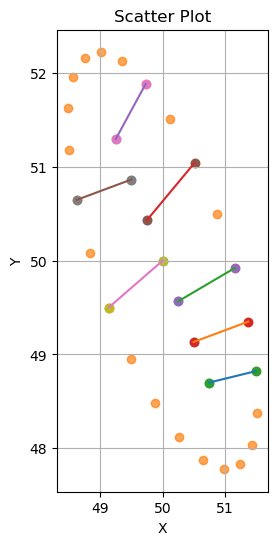

In [130]:
fig = figure("pyplot_scatterplot",figsize=(6,6))
ax = PyPlot.axes()
subplot(122)
# ax = fig[:add_subplot](1,2,2);
scatter(P.points[1,:],P.points[2,:],alpha=0.7)
scatter(Q.points[1,:],Q.points[2,:],alpha=0.7)

PyPlot.title("Scatter Plot")
xlabel("X")
ylabel("Y")
grid(true)
# gcf() # Needed for IJulia to plot inline
solOther = sparse(sol_pool[rand(1:cnt),:,:])
for (x,y,v) in zip(findnz(solOther)...)
    
    x_pos = [P.points[:,x][1], Q.points[:,y][1]]
    y_pos = [P.points[:,x][2], Q.points[:,y][2]]
    subplot(122)
    scatter(x_pos, y_pos)
    plot(x_pos, y_pos)
end

In [131]:
allSolutions = zeros(cnt, size(P.points)[2]*4)

for index in 1:cnt
    solOther = sparse(sol_pool[index,:,:])
    line = zeros(0)
    for (x,y,v) in zip(findnz(solOther)...)
        P_pos = [P.points[:,x][1], P.points[:,x][2]]
        Q_pos = [Q.points[:,y][1], Q.points[:,y][2]]
        append!(line, P_pos)
        append!(line, Q_pos)
    end
    allSolutions[index,:] = line
end
df = DataFrame(allSolutions)
println("Count of solutions:$(size(df)[1])")
CSV.write("../data/artificial/solutions.csv",  df, writeheader=false)

Count of solutions:576


"../data/artificial/solutions.csv"